노트북 요약

- interaction을 통한 기본적인 모델링 진행
  - 사용하는 알고리즘 : svd
  - data : custom_movie_rating.txt

# **Interaction 기반 모델링 순서**

**1. 데이터 로딩 및 탐색** ✅ (현재 구현됨)
- 사용자-영화 평점 데이터 로드
- 기본 통계 확인 (사용자 수, 영화 수, 평점 수)

**2. 탐색적 데이터 분석 (EDA)** ✅ (일부 구현됨)
- 사용자별 평점 개수 분포
- 사용자별 평균 평점 분포
- 영화별 평점 개수 분포
- 평점 분포 (0.5, 1.0, ... 5.0)
- Sparsity(희소성) 확인

**3. 데이터 전처리**
- 최소 평점 개수 필터링 (cold start 문제 완화)
  - 평점이 너무 적은 사용자 제거
  - 평점이 너무 적은 영화 제거
- User ID와 Movie ID를 숫자 인덱스로 매핑

**4. Train/Test 데이터 분할**
- 시간 기반 분할 또는 랜덤 분할
- 일반적으로 80:20 또는 90:10 비율

**5. 모델 학습 (SVD 기반)**
- Surprise 라이브러리 사용
- SVD 파라미터 설정 (n_factors, n_epochs, lr_all, reg_all)
- GridSearch로 하이퍼파라미터 튜닝 (선택적)

**6. 모델 평가**
- RMSE, MAE 등의 metric 계산
- Train/Test 성능 비교

**7. 추천 생성**
- 사용자가 아직 평가하지 않은 영화에 대해 예측
- Top-N 추천 생성

**8. 결과 분석**
- 추천 영화 확인
- 다양성, 참신성 등 추가 지표 분석

현재 노트북은 **1단계와 2단계 초반**까지만 구현되어 있습니다. 다음 단계들을 구현해드릴까요?

# Load Data

In [1]:
import pandas as pd

DATA_PATH = '../../data_scraping/data/'

def load_data():
    print("\n사용자 평점 데이터 로딩 중...")
    ratings = []
    with open(DATA_PATH + 'custom_movie_rating.txt', 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('/')
            if len(parts) >= 4:
                try:
                    ratings.append({
                        'user_id': parts[0],
                        'movie_id': parts[1],
                        'movie_title': parts[2],
                        'rating': float(parts[3])
                    })
                except ValueError:
                    continue

    df_ratings = pd.DataFrame(ratings)
    print(f"평점 데이터: {len(df_ratings)}개")
    print(f"고유 사용자 수: {df_ratings['user_id'].nunique()}")
    print(f"고유 영화 수: {df_ratings['movie_id'].nunique()}")
    
    return df_ratings

df_ratings = load_data()


사용자 평점 데이터 로딩 중...
평점 데이터: 1104355개
고유 사용자 수: 1371
고유 영화 수: 34859


In [2]:
df_ratings

,user_id,movie_id,movie_title,rating
0,ZBm5R0Mj7qd46,m5XKVDL,양자물리학,3.0
1,ZBm5R0Mj7qd46,m5Nn2GE,영화로운 작음,3.5
2,ZBm5R0Mj7qd46,mWvq0vZ,내 방,2.5
3,ZBm5R0Mj7qd46,mdKpyBk,성적표의 김민영,3.0
4,ZBm5R0Mj7qd46,mOopbwm,킹덤4: 대장군의 귀환,3.0
...,...,...,...,...
1104350,8BRve2JMQ56VJ,m45ngDW,반지의 제왕: 왕의 귀환,4.0
1104351,8BRve2JMQ56VJ,mOk66kW,브루스 올마이티,4.0
1104352,8BRve2JMQ56VJ,m533Lw5,스텝업 2 - 더 스트리트,4.0
1104353,8BRve2JMQ56VJ,mWp1EmO,은교,3.0


# EDA

,count
count,1147.000000
mean,793.081081
std,659.715673
min,1.000000
25%,351.000000
50%,645.000000
75%,1061.000000
max,6197.000000


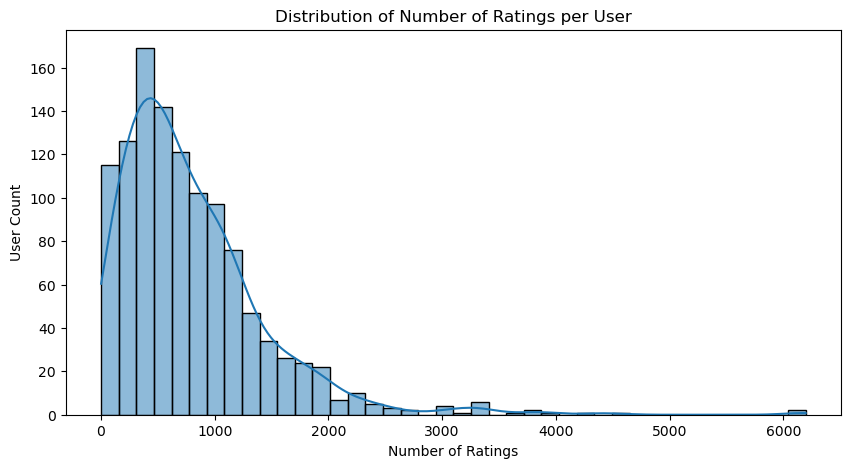

,mean_rating
count,1147.000000
mean,3.386468
std,0.397785
min,1.521008
25%,3.164117
50%,3.407576
75%,3.627383
max,5.000000


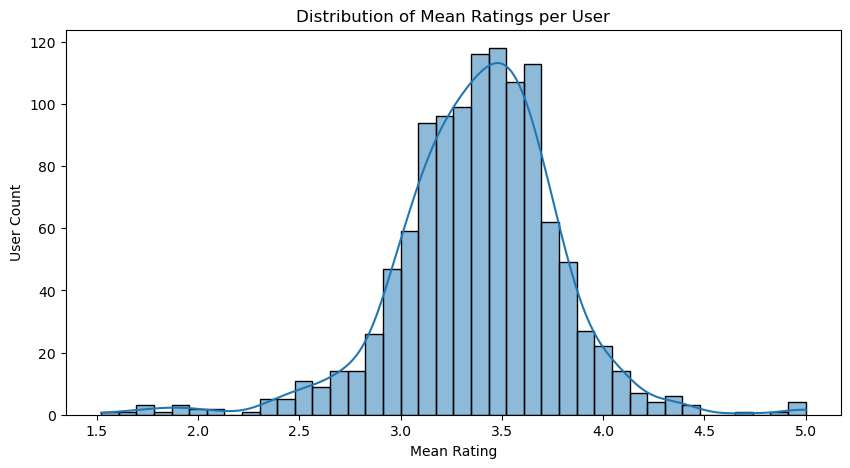

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def explore_user_ratings(df_ratings):
    """
    사용자별 평점 수, 평균 평점의 통계와 분포를 시각화하는 함수
    """
    # Ignore matplotlib font warnings
    warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

    # Show statistics for number of ratings per user
    user_rating_counts = df_ratings.groupby('user_id').size().reset_index(name='count')
    display(user_rating_counts.describe())

    # Visualization: distribution of number of ratings per user
    plt.figure(figsize=(10,5))
    sns.histplot(user_rating_counts['count'], bins=40, kde=True)
    plt.title('Distribution of Number of Ratings per User')
    plt.xlabel('Number of Ratings')
    plt.ylabel('User Count')
    plt.show()

    # Show statistics for mean rating per user
    user_mean_ratings = df_ratings.groupby('user_id')['rating'].mean().reset_index(name='mean_rating')
    display(user_mean_ratings.describe())

    # Visualization: distribution of mean ratings per user
    plt.figure(figsize=(10,5))
    sns.histplot(user_mean_ratings['mean_rating'], bins=40, kde=True)
    plt.title('Distribution of Mean Ratings per User')
    plt.xlabel('Mean Rating')
    plt.ylabel('User Count')
    plt.show()

# 필요할 때 이렇게 사용: explore_user_ratings(df_ratings)
explore_user_ratings(df_ratings)

In [14]:
# Sparsity 계산
n_users = df_ratings['user_id'].nunique()
n_movies = df_ratings['movie_id'].nunique()
n_ratings = len(df_ratings)

# 전체 가능한 셀의 수
total_possible_ratings = n_users * n_movies

# Density (밀도) = 실제로 채워진 비율
density = n_ratings / total_possible_ratings

# Sparsity (희소성) = 비어있는 비율
sparsity = 1 - density

print(f"\n=== Sparsity 분석 ===")
print(f"전체 사용자 수: {n_users:,}")
print(f"전체 영화 수: {n_movies:,}")
print(f"실제 평점 수: {n_ratings:,}")
print(f"전체 가능한 평점 수: {total_possible_ratings:,}")
print(f"\nDensity (밀도): {density*100:.4f}%")
print(f"Sparsity (희소성): {sparsity*100:.4f}%")
print(f"\n해석: 전체 사용자-영화 조합 중 {sparsity*100:.4f}%가 비어있습니다.")



=== Sparsity 분석 ===
전체 사용자 수: 1,147
전체 영화 수: 32,843
실제 평점 수: 909,664
전체 가능한 평점 수: 37,670,921

Density (밀도): 2.4148%
Sparsity (희소성): 97.5852%

해석: 전체 사용자-영화 조합 중 97.5852%가 비어있습니다.


sparsity가 너무 높나?
- 도메인 특성을 생각해보면 높은 건 아니다.

중요한 건 데이터의 양
- 데이터 크기가 충분한지
- 사용자별 평점 개수, 영화별 평점 개수가 충분한지 (각 사용자 최소 10~20개, 각 영화 5~10개)

MF는 sparisty에 강함
- 95~99%도 괜찮다고 함

In [25]:
# Cold User와 Cold Movie 필터링 함수화

def filter_by_min_counts(df, min_user_ratings=30, min_movie_ratings=10, verbose=True):
    """
    지정한 기준 이상 평점을 가진 user/movie만 남도록 데이터프레임 필터링.
    Args:
        df: 평점 데이터프레임 (user_id, movie_id 필수)
        min_user_ratings: 사용자가 최소 남겨야 하는 평점 개수
        min_movie_ratings: 영화가 최소 받아야 하는 평점 개수
        verbose: 각 단계별 개수 출력 여부
    Returns:
        df_filtered: 필터링된 데이터프레임
    """
    user_counts = df.groupby('user_id').size()
    movie_counts = df.groupby('movie_id').size()
    
    if verbose:
        print(f"[필터링 전] 사용자 수: {len(user_counts)}, 영화 수: {len(movie_counts)}")

    valid_users = user_counts[user_counts >= min_user_ratings].index
    valid_movies = movie_counts[movie_counts >= min_movie_ratings].index
    
    if verbose:
        print(f"[필터 적용] min_user_ratings: {min_user_ratings}, min_movie_ratings: {min_movie_ratings}")
        print(f"조건 통과 사용자 수: {len(valid_users)}, 조건 통과 영화 수: {len(valid_movies)}")
    
    df_filtered = df[
        (df['user_id'].isin(valid_users)) & 
        (df['movie_id'].isin(valid_movies))
    ].copy()
    
    filtered_user_counts = df_filtered.groupby('user_id').size()
    filtered_movie_counts = df_filtered.groupby('movie_id').size()
    if verbose:
        print(f"[필터링 후] 사용자 수: {len(filtered_user_counts)}, 영화 수: {len(filtered_movie_counts)}")
    
    return df_filtered

# 필터링 기준 설정
MIN_USER_RATINGS = 30
MIN_MOVIE_RATINGS = 10

print("=== 필터링 전 ===")
print(f"사용자 수: {df_ratings['user_id'].nunique()}")
print(f"영화 수: {df_ratings['movie_id'].nunique()}")
print(f"평점 수: {len(df_ratings)}")

user_counts = df_ratings.groupby('user_id').size()
movie_counts = df_ratings.groupby('movie_id').size()
print(f"사용자별 최소 평점 개수: {user_counts.min()}")
print(f"사용자별 최대 평점 개수: {user_counts.max()}")
print(f"영화별 최소 평점 개수: {movie_counts.min()}")
print(f"영화별 최대 평점 개수: {movie_counts.max()}")

df_filtered = filter_by_min_counts(df_ratings, MIN_USER_RATINGS, MIN_MOVIE_RATINGS)

print(f"\n=== 필터링 후 ===")
print(f"사용자 수: {df_filtered['user_id'].nunique()}")
print(f"영화 수: {df_filtered['movie_id'].nunique()}")
print(f"평점 수: {len(df_filtered)}")

user_counts_filtered = df_filtered.groupby('user_id').size()
movie_counts_filtered = df_filtered.groupby('movie_id').size()
print(f"필터링 후 사용자별 최소 평점 개수: {user_counts_filtered.min()}")
print(f"필터링 후 영화별 최소 평점 개수: {movie_counts_filtered.min()}")

print(f"\n=== 제거된 데이터 ===")
print(f"제거된 사용자 수: {df_ratings['user_id'].nunique() - df_filtered['user_id'].nunique()}")
print(f"제거된 영화 수: {df_ratings['movie_id'].nunique() - df_filtered['movie_id'].nunique()}")
print(f"제거된 평점 수: {len(df_ratings) - len(df_filtered)}")
print(f"데이터 보존율: {len(df_filtered)/len(df_ratings)*100:.2f}%")

# 필터링 후 Sparsity 계산
n_users_filtered = df_filtered['user_id'].nunique()
n_movies_filtered = df_filtered['movie_id'].nunique()
n_ratings_filtered = len(df_filtered)
total_possible_filtered = n_users_filtered * n_movies_filtered
sparsity_filtered = 1 - (n_ratings_filtered / total_possible_filtered)

print(f"\n=== Sparsity 비교 ===")
print(f"필터링 전 Sparsity: {sparsity*100:.4f}%")
print(f"필터링 후 Sparsity: {sparsity_filtered*100:.4f}%")
print(f"Sparsity 감소: {(sparsity - sparsity_filtered)*100:.4f}%p")

=== 필터링 전 ===
사용자 수: 1147
영화 수: 32843
평점 수: 909664
사용자별 최소 평점 개수: 1
사용자별 최대 평점 개수: 6197
영화별 최소 평점 개수: 1
영화별 최대 평점 개수: 903
[필터링 전] 사용자 수: 1147, 영화 수: 32843
[필터 적용] min_user_ratings: 30, min_movie_ratings: 10
조건 통과 사용자 수: 1121, 조건 통과 영화 수: 9222
[필터링 후] 사용자 수: 1121, 영화 수: 9222

=== 필터링 후 ===
사용자 수: 1121
영화 수: 9222
평점 수: 851330
필터링 후 사용자별 최소 평점 개수: 29
필터링 후 영화별 최소 평점 개수: 9

=== 제거된 데이터 ===
제거된 사용자 수: 26
제거된 영화 수: 23621
제거된 평점 수: 58334
데이터 보존율: 93.59%

=== Sparsity 비교 ===
필터링 전 Sparsity: 97.5852%
필터링 후 Sparsity: 91.7649%
Sparsity 감소: 5.8203%p


,count
count,1121.000000
mean,759.438002
std,573.440869
min,29.000000
25%,354.000000
50%,633.000000
75%,1031.000000
max,5267.000000


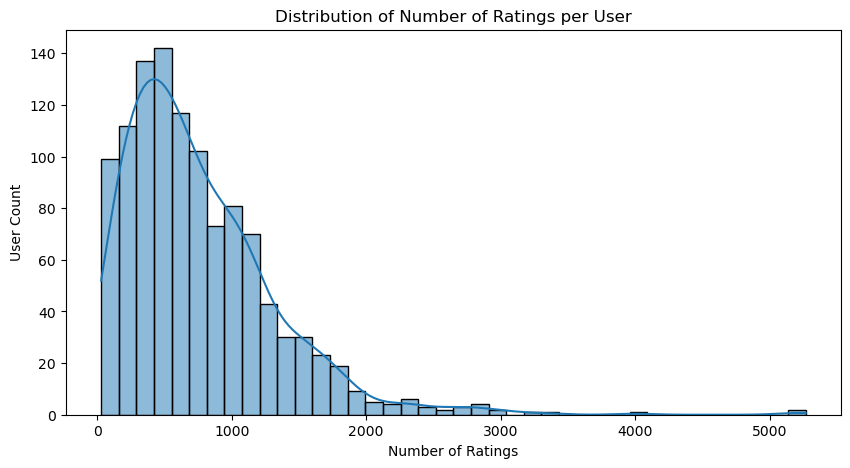

,mean_rating
count,1121.000000
mean,3.394642
std,0.379214
min,1.553906
25%,3.189306
50%,3.417866
75%,3.632094
max,5.000000


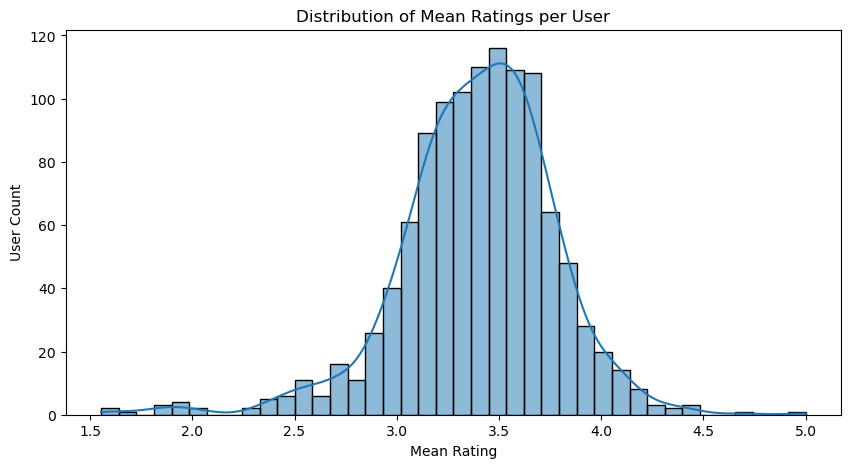

In [21]:
explore_user_ratings(df_filtered)

# Preprocessing

In [26]:
df = load_data()
filtered_df = filter_by_min_counts(df, min_user_ratings=30, min_movie_ratings=10)


사용자 평점 데이터 로딩 중...
평점 데이터: 909664개
고유 사용자 수: 1147
고유 영화 수: 32843
[필터링 전] 사용자 수: 1147, 영화 수: 32843
[필터 적용] min_user_ratings: 30, min_movie_ratings: 10
조건 통과 사용자 수: 1121, 조건 통과 영화 수: 9222
[필터링 후] 사용자 수: 1121, 영화 수: 9222


In [29]:
def preprocess_id_mapping(df):
    """
    User ID와 Movie ID를 숫자 인덱스로 매핑하는 전처리 함수
    - 입력: DataFrame (user_id, movie_id 필수)
    - 출력: 
        df_new (user_idx, movie_idx 추가),
        user_to_idx, idx_to_user, movie_to_idx, idx_to_movie
    """
    print("=== 전처리: ID 매핑 ===\n")
    
    # User ID 매핑 (문자열 -> 연속된 정수)
    unique_users = df['user_id'].unique()
    user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
    idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
    
    # Movie ID 매핑 (문자열 -> 연속된 정수)
    unique_movies = df['movie_id'].unique()
    movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(unique_movies)}
    idx_to_movie = {idx: movie_id for movie_id, idx in movie_to_idx.items()}
    
    # 새로운 컬럼 추가 (복사본에서)
    df_new = df.copy()
    df_new['user_idx'] = df_new['user_id'].map(user_to_idx)
    df_new['movie_idx'] = df_new['movie_id'].map(movie_to_idx)
    
    print(f"사용자 매핑: {len(user_to_idx)}명")
    print(f"  - 원본 예시: {list(user_to_idx.items())[:3]}")
    print(f"\n영화 매핑: {len(movie_to_idx)}개")
    print(f"  - 원본 예시: {list(movie_to_idx.items())[:3]}")
    
    # 데이터 확인
    print(f"\n전처리된 데이터:")
    display(df_new[['user_id', 'user_idx', 'movie_id', 'movie_idx', 'movie_title', 'rating']].head(10))
    
    # 최종 데이터 통계
    print(f"\n=== 최종 데이터 통계 ===")
    print(f"사용자 수: {df_new['user_idx'].nunique()}")
    print(f"영화 수: {df_new['movie_idx'].nunique()}")
    print(f"평점 수: {len(df_new)}")
    print(f"평점 범위: {df_new['rating'].min()} ~ {df_new['rating'].max()}")
    print(f"평균 평점: {df_new['rating'].mean():.2f}")
    
    return df_new, user_to_idx, idx_to_user, movie_to_idx, idx_to_movie

# 실제 사용
df_filtered, user_to_idx, idx_to_user, movie_to_idx, idx_to_movie = preprocess_id_mapping(df_filtered)

=== 전처리: ID 매핑 ===

사용자 매핑: 1121명
  - 원본 예시: [('ZBm5R0Mj7qd46', 0), ('RE952m91MvQ72', 1), ('24BqEn96mvrjn', 2)]

영화 매핑: 9222개
  - 원본 예시: [('m5XKVDL', 0), ('mdKpyBk', 1), ('mdB7Joq', 2)]

전처리된 데이터:


,user_id,user_idx,movie_id,movie_idx,movie_title,rating
0,ZBm5R0Mj7qd46,0,m5XKVDL,0,양자물리학,3.0
3,ZBm5R0Mj7qd46,0,mdKpyBk,1,성적표의 김민영,3.0
9,ZBm5R0Mj7qd46,0,mdB7Joq,2,글래디에이터 Ⅱ,2.5
10,ZBm5R0Mj7qd46,0,m5nwAgn,3,킹덤,3.0
11,ZBm5R0Mj7qd46,0,mWq1YVl,4,미망,3.0
15,ZBm5R0Mj7qd46,0,mOAk0kl,5,범죄도시2,3.0
16,ZBm5R0Mj7qd46,0,m5Q9ywD,6,그대들은 어떻게 살 것인가,2.5
17,ZBm5R0Mj7qd46,0,mBOkwpO,7,천공의 성 라퓨타,2.5
18,ZBm5R0Mj7qd46,0,mdj22GN,8,클로즈 유어 아이즈,4.0
19,ZBm5R0Mj7qd46,0,m5x1xva,9,댓글부대,3.0



=== 최종 데이터 통계 ===
사용자 수: 1121
영화 수: 9222
평점 수: 851330
평점 범위: 0.5 ~ 5.0
평균 평점: 3.32


In [31]:
df_filtered[df_filtered['movie_idx']==0]

,user_id,movie_id,movie_title,rating,user_idx,movie_idx
0,ZBm5R0Mj7qd46,m5XKVDL,양자물리학,3.0,0,0
9902,djaxbK8MDqLw8,m5XKVDL,양자물리학,3.0,14,0
12512,YMKqmbLYlvloD,m5XKVDL,양자물리학,2.0,19,0
18235,YMKqmDLGrxloD,m5XKVDL,양자물리학,3.0,30,0
26803,6nkPvrZNvgarB,m5XKVDL,양자물리학,3.0,48,0
...,...,...,...,...,...,...
852244,yKZx3VMOO54dJ,m5XKVDL,양자물리학,0.5,1050,0
852655,YMKqm8V4exloD,m5XKVDL,양자물리학,1.0,1052,0
876551,6nkPvrj3rvgar,m5XKVDL,양자물리학,2.0,1081,0
892083,ZWpqMglal5rkn,m5XKVDL,양자물리학,3.0,1097,0


# Train/Test Split & SVD Modeling

In [35]:
# Surprise 라이브러리 설치 (필요시)
# !pip install scikit-surprise

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
import numpy as np

print("Surprise 라이브러리 import 완료")

Surprise 라이브러리 import 완료


In [36]:
# Surprise Dataset 준비
# Surprise 라이브러리는 (user_id, item_id, rating) 형태의 데이터를 요구합니다

print("=== Surprise Dataset 준비 ===\n")

# Reader 객체 생성 (평점 범위 지정)
reader = Reader(rating_scale=(0.5, 5.0))

# DataFrame을 Surprise Dataset으로 변환
# user_id와 movie_id를 그대로 사용 (매핑된 idx가 아닌 원본 ID 사용)
data = Dataset.load_from_df(
    df_filtered[['user_id', 'movie_id', 'rating']], 
    reader
)

print(f"데이터셋 생성 완료")
print(f"- 총 평점 수: {len(df_filtered)}")
print(f"- 평점 범위: 0.5 ~ 5.0")


=== Surprise Dataset 준비 ===

데이터셋 생성 완료
- 총 평점 수: 851330
- 평점 범위: 0.5 ~ 5.0


In [43]:
# Train/Test Split
# test_size=0.2 -> 80% train, 20% test
# random_state: 재현성을 위한 시드값

print("=== Train/Test Split ===\n")

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

print(f"Train set size: {trainset.n_ratings:,}")
print(f"Test set size: {len(testset):,}")
print(f"\nTrain set 통계:")
print(f"  - 사용자 수: {trainset.n_users}")
print(f"  - 영화 수: {trainset.n_items}")
print(f"  - 평점 수: {trainset.n_ratings}")
print(f"  - 전체 셀 수: {trainset.n_users * trainset.n_items:,}")
print(f"  - Train Sparsity: {(1 - trainset.n_ratings / (trainset.n_users * trainset.n_items))*100:.2f}%")


=== Train/Test Split ===

Train set size: 681,064
Test set size: 170,266

Train set 통계:
  - 사용자 수: 1121
  - 영화 수: 9222
  - 평점 수: 681064
  - 전체 셀 수: 10,337,862
  - Train Sparsity: 93.41%


In [57]:
# SVD 모델 생성 및 학습
print("=== SVD 모델 학습 ===\n")

# SVD 하이퍼파라미터 설정
svd_params = {
    'n_factors': 50,      # latent factor 개수
    'n_epochs': 20,        # 학습 반복 횟수
    'lr_all': 0.005,       # learning rate
    'reg_all': 0.02,       # regularization term
    'random_state': 42,    # 재현성을 위한 시드값
    'verbose': True        # 학습 진행 상황 출력
}

print(f"SVD 파라미터:")
for key, value in svd_params.items():
    print(f"  - {key}: {value}")

print("\n학습 시작...\n")

# SVD 모델 생성 및 학습
svd_model = SVD(**svd_params)
svd_model.fit(trainset)

print("\n✅ 학습 완료!")


=== SVD 모델 학습 ===

SVD 파라미터:
  - n_factors: 50
  - n_epochs: 20
  - lr_all: 0.005
  - reg_all: 0.02
  - random_state: 42
  - verbose: True

학습 시작...

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19

✅ 학습 완료!


In [58]:
# 모델 평가
print("=== 모델 평가 ===\n")

# Test set에 대한 예측
print("Test set 평가:")
test_predictions = svd_model.test(testset)
test_rmse = accuracy.rmse(test_predictions, verbose=True)
test_mae = accuracy.mae(test_predictions, verbose=True)

# Train set에 대한 평가 (overfitting 확인용)
print("\n\nTrain set 평가:")
train_testset = trainset.build_testset()
train_predictions = svd_model.test(train_testset)
train_rmse = accuracy.rmse(train_predictions, verbose=True)
train_mae = accuracy.mae(train_predictions, verbose=True)

# 결과 요약
print("\n\n=== 평가 결과 요약 ===")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}")
print(f"Train MAE:  {train_mae:.4f}")
print(f"Test MAE:   {test_mae:.4f}")

# Overfitting 체크
if test_rmse - train_rmse > 0.1:
    print("\n⚠️  경고: Test RMSE가 Train RMSE보다 유의미하게 높습니다. Overfitting 가능성이 있습니다.")
elif test_rmse - train_rmse < 0.05:
    print("\n✅ Train과 Test 성능이 비슷합니다. 적절한 일반화가 이루어졌습니다.")
else:
    print("\n✅ Train과 Test 성능 차이가 적절한 수준입니다.")


=== 모델 평가 ===

Test set 평가:
RMSE: 0.7134
MAE:  0.5418


Train set 평가:
RMSE: 0.6264
MAE:  0.4816


=== 평가 결과 요약 ===
Train RMSE: 0.6264
Test RMSE:  0.7134
Train MAE:  0.4816
Test MAE:   0.5418

✅ Train과 Test 성능 차이가 적절한 수준입니다.


In [59]:
test_predictions[:5]

[Prediction(uid='yKZx3nnmQE54d', iid='m6dRw45', r_ui=2.5, est=2.646660661025817, details={'was_impossible': False}),
 Prediction(uid='ld0q0Ebz3v6Xn', iid='m5m1J75', r_ui=3.5, est=3.474203148047567, details={'was_impossible': False}),
 Prediction(uid='17ovVgZyP5zyn', iid='mpWpQMO', r_ui=4.0, est=3.3891567484847127, details={'was_impossible': False}),
 Prediction(uid='87Gv7D7JD5E6o', iid='mWvqy0E', r_ui=2.5, est=3.0326300001944166, details={'was_impossible': False}),
 Prediction(uid='ZBm5RNEVn5d46', iid='mWq1ag2', r_ui=3.5, est=3.294922657581155, details={'was_impossible': False})]

In [60]:
train_testset[:5]

[('dP8v61VQMqWeJ', 'mOo0DqZ', 3.5),
 ('dP8v61VQMqWeJ', 'mdEwMvg', 3.0),
 ('dP8v61VQMqWeJ', 'mO01jxd', 4.0),
 ('dP8v61VQMqWeJ', 'mgdM9ld', 3.5),
 ('dP8v61VQMqWeJ', 'm5rQJmd', 4.0)]

# Interaction으로 Item-Based Filtering 구현

**Item-Based Collaborative Filtering 원리:**
1. 영화 간의 유사도 계산 (user-item interaction 기반)
2. 사용자가 본 영화와 유사한 영화 찾기
3. 유사도 가중 평균으로 평점 예측

**구현 방식:**
- User-Item Matrix 생성
- 영화 간 코사인 유사도 계산
- Top-K 유사 영화 기반 평점 예측

In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import time

print("Item-Based Filtering 라이브러리 import 완료")

Item-Based Filtering 라이브러리 import 완료


In [5]:
import sys
from pathlib import Path

# modeling 디렉토리를 Python 경로에 추가
modeling_dir = Path().absolute().parent
if str(modeling_dir) not in sys.path:
    sys.path.insert(0, str(modeling_dir))

from utils import data

df = data.load_data()
df_filtered = data.filter_by_min_counts(df)
df_preprocessed, id_mapping = data.preprocess_id_mapping(df_filtered)


사용자 평점 데이터 로딩 중...
평점 데이터: 909,664개
고유 사용자 수: 1,147명
고유 영화 수: 32,843개

[필터링 전] 사용자 수: 1,147명, 영화 수: 32,843개
[필터 적용] min_user_ratings: 30, min_movie_ratings: 10
조건 통과 사용자 수: 1,121명, 조건 통과 영화 수: 9,222개
[필터링 후] 사용자 수: 1,121명, 영화 수: 9,222개
필터링된 평점 수: 851,330개 (제거: 58,334개)

=== 전처리: ID 매핑 ===

사용자 매핑: 1,121명
  - 원본 예시: [('17ovV0EW1xzyn', 0), ('17ovV1eblqzyn', 1), ('17ovV1r2Pqzyn', 2)]

영화 매핑: 9,222개
  - 원본 예시: [('m15G1rO', 0), ('m15G2Bd', 1), ('m15G3D5', 2)]

전처리된 데이터:
      user_id  user_idx movie_id  movie_idx    movie_title  rating
ZBm5R0Mj7qd46       812  m5XKVDL       1027          양자물리학     3.0
ZBm5R0Mj7qd46       812  mdKpyBk       8166       성적표의 김민영     3.0
ZBm5R0Mj7qd46       812  mdB7Joq       7649       글래디에이터 Ⅱ     2.5
ZBm5R0Mj7qd46       812  m5nwAgn       2244             킹덤     3.0
ZBm5R0Mj7qd46       812  mWq1YVl       6276             미망     3.0
ZBm5R0Mj7qd46       812  mOAk0kl       3895          범죄도시2     3.0
ZBm5R0Mj7qd46       812  m5Q9ywD        825 그대들은 어떻게 살 것인가  

In [6]:
# Step 1: Train/Test 데이터 분리 (item-based용)
print("=== Item-Based Filtering을 위한 데이터 분리 ===\n")

from sklearn.model_selection import train_test_split as sklearn_train_test_split

# 80:20 분할
train_df, test_df = sklearn_train_test_split(
    df_preprocessed, 
    test_size=0.2, 
    random_state=42
)

print(f"Train 데이터: {len(train_df):,}개")
print(f"Test 데이터: {len(test_df):,}개")
print(f"Train 사용자 수: {train_df['user_idx'].nunique()}")
print(f"Train 영화 수: {train_df['movie_idx'].nunique()}")
print(f"Test 사용자 수: {test_df['user_idx'].nunique()}")
print(f"Test 영화 수: {test_df['movie_idx'].nunique()}")

=== Item-Based Filtering을 위한 데이터 분리 ===

Train 데이터: 681,064개
Test 데이터: 170,266개
Train 사용자 수: 1121
Train 영화 수: 9222
Test 사용자 수: 1121
Test 영화 수: 9075


In [7]:
# Step 2: User-Item Matrix 생성 (Train 데이터 기반)
print("=== User-Item Matrix 생성 ===\n")

n_users = df_preprocessed['user_idx'].nunique()
n_movies = df_preprocessed['movie_idx'].nunique()

# Sparse Matrix 생성 (메모리 효율적)
user_item_matrix = csr_matrix(
    (train_df['rating'], (train_df['user_idx'], train_df['movie_idx'])),
    shape=(n_users, n_movies)
)

print(f"Matrix Shape: {user_item_matrix.shape} (users x movies)")
print(f"Total cells: {n_users * n_movies:,}")
print(f"Non-zero cells: {user_item_matrix.nnz:,}")
print(f"Sparsity: {(1 - user_item_matrix.nnz / (n_users * n_movies)) * 100:.2f}%")
print(f"Memory size: {user_item_matrix.data.nbytes / (1024**2):.2f} MB")


=== User-Item Matrix 생성 ===

Matrix Shape: (1121, 9222) (users x movies)
Total cells: 10,337,862
Non-zero cells: 681,064
Sparsity: 93.41%
Memory size: 5.20 MB


In [8]:
# Step 3: Item-Item 유사도 계산 (코사인 유사도)
print("=== Item-Item 유사도 계산 ===\n")
print("계산 중... (시간이 다소 걸릴 수 있습니다)")

start_time = time.time()

# User-Item Matrix를 전치하여 Item-User Matrix로 변환
item_user_matrix = user_item_matrix.T

# 코사인 유사도 계산 (item x item)
item_similarity = cosine_similarity(item_user_matrix, dense_output=False)

elapsed_time = time.time() - start_time

print(f"\n✅ 유사도 계산 완료!")
print(f"Item Similarity Matrix Shape: {item_similarity.shape} (movies x movies)")
print(f"계산 시간: {elapsed_time:.2f}초")
print(f"Non-zero similarities: {item_similarity.nnz:,}")
print(f"Memory size: {item_similarity.data.nbytes / (1024**2):.2f} MB")


=== Item-Item 유사도 계산 ===

계산 중... (시간이 다소 걸릴 수 있습니다)

✅ 유사도 계산 완료!
Item Similarity Matrix Shape: (9222, 9222) (movies x movies)
계산 시간: 1.57초
Non-zero similarities: 68,435,670
Memory size: 522.12 MB


In [9]:
# item_similarity 샘플 10개만 확인하려면 (dense하지 않은 형태, 즉 nonzero만)
from random import sample
import numpy as np

# 아이템 개수 N
n_movies = item_similarity.shape[0]
# 무작위 movie_idx 10개 뽑기
sample_movie_idx = sample(range(n_movies), 10)

for idx in sample_movie_idx:
    # 해당 영화와 다른 영화들과의 유사도 중 nonzero만 (즉, 실제로 유사한 것만)
    sim_row = item_similarity[idx].tocoo()
    print(f"\n[movie_idx={idx}] nonzero similarity count: {sim_row.nnz}")
    # 최대 5개만 프린트 (index, similarity)
    shown = 0
    for m_idx, sim in zip(sim_row.col, sim_row.data):
        print(f"  -> movie_idx={m_idx}, similarity={sim:.4f}")
        shown += 1
        if shown >= 5:
            break


[movie_idx=8428] nonzero similarity count: 9220
  -> movie_idx=3758, similarity=0.0192
  -> movie_idx=9109, similarity=0.0252
  -> movie_idx=2882, similarity=0.0441
  -> movie_idx=2055, similarity=0.0016
  -> movie_idx=2539, similarity=0.0370

[movie_idx=765] nonzero similarity count: 7393
  -> movie_idx=9119, similarity=0.0315
  -> movie_idx=9087, similarity=0.0196
  -> movie_idx=8669, similarity=0.0329
  -> movie_idx=7448, similarity=0.0353
  -> movie_idx=7034, similarity=0.0350

[movie_idx=9164] nonzero similarity count: 6640
  -> movie_idx=9215, similarity=0.0574
  -> movie_idx=9206, similarity=0.0424
  -> movie_idx=9194, similarity=0.0633
  -> movie_idx=9175, similarity=0.0388
  -> movie_idx=9174, similarity=0.0572

[movie_idx=305] nonzero similarity count: 5800
  -> movie_idx=9176, similarity=0.0171
  -> movie_idx=9131, similarity=0.0336
  -> movie_idx=9046, similarity=0.0189
  -> movie_idx=9023, similarity=0.0238
  -> movie_idx=8849, similarity=0.0288

[movie_idx=450] nonzero s

In [10]:
# Step 4: Item-Based 예측 함수 구현
def predict_item_based(user_idx, movie_idx, user_item_matrix, item_similarity, k=50):
    """
    Item-Based Collaborative Filtering 예측
    
    Args:
        user_idx: 사용자 인덱스
        movie_idx: 영화 인덱스
        user_item_matrix: User-Item 평점 행렬
        item_similarity: Item-Item 유사도 행렬
        k: Top-K 유사 아이템 개수
    
    Returns:
        predicted_rating: 예측 평점
    """
    # 사용자가 평가한 영화들
    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    rated_items = np.where(user_ratings > 0)[0]
    
    if len(rated_items) == 0:
        # 사용자가 아무것도 평가하지 않았으면 전체 평균 반환
        return user_item_matrix.data.mean()
    
    # 타겟 영화와의 유사도
    similarities = item_similarity[movie_idx].toarray().flatten()
    
    # 사용자가 평가한 영화들 중에서만 유사도 추출
    sim_scores = similarities[rated_items]
    user_ratings_filtered = user_ratings[rated_items]
    
    # 유사도가 0보다 큰 것만 선택
    valid_mask = sim_scores > 0
    sim_scores = sim_scores[valid_mask]
    user_ratings_filtered = user_ratings_filtered[valid_mask]
    
    if len(sim_scores) == 0:
        # 유사한 영화가 없으면 사용자의 평균 평점 반환
        return user_ratings[rated_items].mean()
    
    # Top-K 유사 아이템 선택
    if len(sim_scores) > k:
        top_k_idx = np.argsort(sim_scores)[-k:]
        sim_scores = sim_scores[top_k_idx]
        user_ratings_filtered = user_ratings_filtered[top_k_idx]
    
    # 유사도 가중 평균
    if sim_scores.sum() == 0:
        return user_ratings_filtered.mean()
    
    predicted = np.dot(sim_scores, user_ratings_filtered) / sim_scores.sum()
    
    # 평점 범위 제한 (0.5 ~ 5.0)
    return np.clip(predicted, 0.5, 5.0)

print("✅ Item-Based 예측 함수 정의 완료")


✅ Item-Based 예측 함수 정의 완료


In [11]:
# Step 5: Test Set 평가
print("=== Item-Based Filtering 평가 ===\n")
print("예측 중... (시간이 다소 걸릴 수 있습니다)")

start_time = time.time()

# Test 데이터에 대한 예측
predictions = []
actuals = []

# 샘플링 (전체 테스트 데이터가 너무 크면 샘플링)
test_sample = test_df.sample(n=min(10000, len(test_df)), random_state=42)

for idx, row in test_sample.iterrows():
    user_idx = row['user_idx']
    movie_idx = row['movie_idx']
    actual_rating = row['rating']
    
    pred_rating = predict_item_based(
        user_idx, movie_idx, user_item_matrix, item_similarity, k=50
    )
    
    predictions.append(pred_rating)
    actuals.append(actual_rating)
    
    # 진행 상황 출력 (1000개마다)
    if len(predictions) % 1000 == 0:
        print(f"진행: {len(predictions)}/{len(test_sample)}")

predictions = np.array(predictions)
actuals = np.array(actuals)

elapsed_time = time.time() - start_time

print(f"\n✅ 예측 완료!")
print(f"예측 시간: {elapsed_time:.2f}초")
print(f"예측 개수: {len(predictions):,}개")


=== Item-Based Filtering 평가 ===

예측 중... (시간이 다소 걸릴 수 있습니다)
진행: 1000/10000
진행: 2000/10000
진행: 3000/10000
진행: 4000/10000
진행: 5000/10000
진행: 6000/10000
진행: 7000/10000
진행: 8000/10000
진행: 9000/10000
진행: 10000/10000

✅ 예측 완료!
예측 시간: 1.59초
예측 개수: 10,000개


In [12]:
# Step 6: 평가 지표 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

print("\n=== Item-Based Filtering 성능 ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

# 예측값 분포 확인
print(f"\n예측값 통계:")
print(f"  - 최소값: {predictions.min():.2f}")
print(f"  - 최대값: {predictions.max():.2f}")
print(f"  - 평균: {predictions.mean():.2f}")
print(f"  - 표준편차: {predictions.std():.2f}")

print(f"\n실제값 통계:")
print(f"  - 평균: {actuals.mean():.2f}")
print(f"  - 표준편차: {actuals.std():.2f}")

# SVD와 비교
print(f"\n=== SVD와 비교 ===")
# print(f"SVD Test RMSE:       {test_rmse:.4f}")
print(f"Item-Based RMSE:     {rmse:.4f}")
# print(f"차이:                {abs(test_rmse - rmse):.4f}")

# if rmse < test_rmse:
#     print("✅ Item-Based가 SVD보다 성능이 좋습니다!")
# else:
#     print("⚠️  SVD가 Item-Based보다 성능이 좋습니다.")



=== Item-Based Filtering 성능 ===
RMSE: 0.8326
MAE:  0.6303

예측값 통계:
  - 최소값: 0.80
  - 최대값: 5.00
  - 평균: 3.60
  - 표준편차: 0.49

실제값 통계:
  - 평균: 3.32
  - 표준편차: 0.97

=== SVD와 비교 ===
Item-Based RMSE:     0.8326


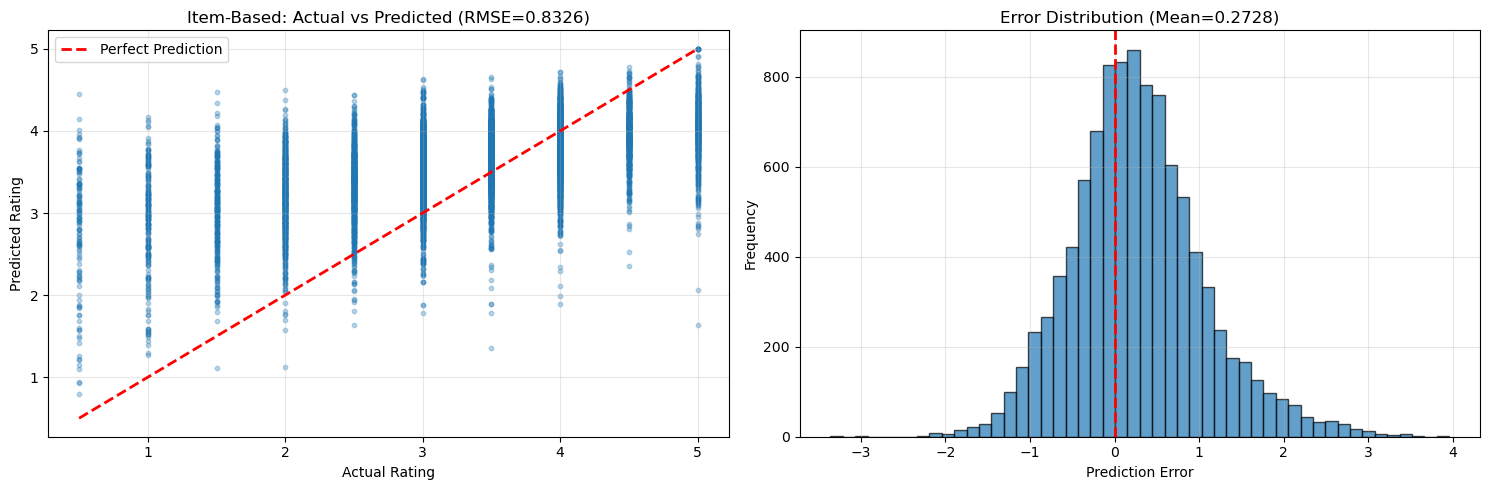

오차 통계:
  - 평균 오차: 0.2728
  - 오차 표준편차: 0.7867


In [13]:
# Step 7: 예측 결과 시각화
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 예측값 vs 실제값 산점도
axes[0].scatter(actuals, predictions, alpha=0.3, s=10)
axes[0].plot([0.5, 5.0], [0.5, 5.0], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Item-Based: Actual vs Predicted (RMSE={rmse:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 오차 분포
errors = predictions - actuals
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Error Distribution (Mean={errors.mean():.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"오차 통계:")
print(f"  - 평균 오차: {errors.mean():.4f}")
print(f"  - 오차 표준편차: {errors.std():.4f}")


In [14]:
# Step 8: 특정 사용자에게 영화 추천하기
def recommend_movies_item_based(user_idx, user_item_matrix, item_similarity, 
                                 idx_to_movie, df_filtered, top_n=10, k=50):
    """
    Item-Based Filtering으로 사용자에게 영화 추천
    
    Args:
        user_idx: 사용자 인덱스
        user_item_matrix: User-Item 평점 행렬
        item_similarity: Item-Item 유사도 행렬
        idx_to_movie: 영화 인덱스 -> 영화 ID 매핑
        df_filtered: 영화 정보가 포함된 DataFrame
        top_n: 추천할 영화 개수
        k: 유사 아이템 개수
    
    Returns:
        recommendations: 추천 영화 리스트 (영화 정보 포함)
    """
    # 사용자가 평가한 영화들
    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    rated_items = np.where(user_ratings > 0)[0]
    
    # 사용자가 평가하지 않은 영화들
    unrated_items = np.where(user_ratings == 0)[0]
    
    # 각 영화에 대한 예측 평점 계산
    predictions = []
    for movie_idx in unrated_items:
        pred_rating = predict_item_based(
            user_idx, movie_idx, user_item_matrix, item_similarity, k=k
        )
        predictions.append((movie_idx, pred_rating))
    
    # 예측 평점 기준으로 정렬
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Top-N 추천
    top_recommendations = predictions[:top_n]
    
    # 추천 결과를 DataFrame으로 변환
    recommendations = []
    for movie_idx, pred_rating in top_recommendations:
        movie_id = idx_to_movie[movie_idx]
        movie_info = df_filtered[df_filtered['movie_idx'] == movie_idx].iloc[0]
        recommendations.append({
            'movie_idx': movie_idx,
            'movie_id': movie_id,
            'movie_title': movie_info['movie_title'],
            'predicted_rating': pred_rating
        })
    
    return pd.DataFrame(recommendations)

print("✅ 추천 함수 정의 완료")


✅ 추천 함수 정의 완료


In [15]:
import pandas as pd

# 예시: 특정 사용자에게 추천
test_user_idx = 0

print(f"=== 사용자 {test_user_idx}에게 Item-Based 추천 ===\n")

# 사용자가 높은 평점을 준 영화들
user_ratings = user_item_matrix[test_user_idx].toarray().flatten()
rated_items = np.where(user_ratings > 0)[0]
high_rated = [(idx, user_ratings[idx]) for idx in rated_items]
high_rated.sort(key=lambda x: x[1], reverse=True)

print("사용자가 높게 평가한 영화 Top 5:")
for i, (movie_idx, rating) in enumerate(high_rated[:5], 1):
    movie_id = id_mapping.idx_to_movie[movie_idx]
    movie_title = df_preprocessed[df_preprocessed['movie_idx'] == movie_idx].iloc[0]['movie_title']
    print(f"{i}. {movie_title} - 평점: {rating:.1f}")

print("\n추천 영화 생성 중...")
recommendations = recommend_movies_item_based(
    test_user_idx, user_item_matrix, item_similarity, 
    id_mapping.idx_to_movie, df_preprocessed, top_n=10, k=50
)

print("\n추천 영화 Top 10:")
display(recommendations)

=== 사용자 0에게 Item-Based 추천 ===

사용자가 높게 평가한 영화 Top 5:
1. 봄날은 간다 - 평점: 5.0
2. 제로 다크 서티 - 평점: 5.0
3. 스포트라이트 - 평점: 5.0
4. 아가씨 - 평점: 5.0
5. 미스 슬로운 - 평점: 5.0

추천 영화 생성 중...

추천 영화 Top 10:


,movie_idx,movie_id,movie_title,predicted_rating
0,5218,mOo0P9a,우리들,4.171201
1,7940,mdEwEgW,멋진 하루,4.164467
2,8980,mnWJ03d,아메리칸 뷰티,4.161327
3,5441,mV53xjW,존 말코비치 되기,4.151361
4,2985,mLOPXO6,밀양,4.146694
5,9038,mpWpBad,파수꾼,4.143663
6,2561,m5xMxbW,만추,4.137786
7,5107,mOl4nEg,지금은맞고그때는틀리다,4.136492
8,3013,mM5rDjO,펀치 드렁크 러브,4.135869
9,2336,m5rQGMm,블루 재스민,4.131287


In [16]:
def find_similar_movies(movie_id, item_similarity, id_mapping, df_preprocessed, top_n=10):
    """
    특정 영화와 유사한 영화들을 찾는 함수
    
    Args:
        movie_id: 찾고자 하는 영화의 ID (문자열)
        item_similarity: Item-Item 유사도 행렬 (movie_idx x movie_idx)
        id_mapping: ID 매핑 객체 (movie_to_idx, idx_to_movie 포함)
        df_preprocessed: 영화 정보가 포함된 DataFrame
        top_n: 반환할 유사 영화 개수
    
    Returns:
        similar_movies_df: 유사한 영화 정보 DataFrame
    """
    # movie_id가 존재하는지 확인
    if movie_id not in id_mapping.movie_to_idx:
        print(f"❌ 영화 ID '{movie_id}'를 찾을 수 없습니다.")
        return None
    
    # movie_id를 movie_idx로 변환
    movie_idx = id_mapping.movie_to_idx[movie_id]
    
    # 해당 영화 정보 출력
    movie_info = df_preprocessed[df_preprocessed['movie_id'] == movie_id].iloc[0]
    print(f"\n=== 기준 영화 ===")
    print(f"영화 ID: {movie_id}")
    print(f"영화 제목: {movie_info['movie_title']}")
    print(f"영화 인덱스: {movie_idx}")
    
    # 해당 영화와 모든 영화들 간의 유사도 추출
    similarities = item_similarity[movie_idx].toarray().flatten()
    
    # 유사도가 0보다 큰 영화들만 선택 (자기 자신 제외)
    similar_indices = []
    for idx, sim in enumerate(similarities):
        if idx != movie_idx and sim > 0:
            similar_indices.append((idx, sim))
    
    # 유사도 기준으로 정렬 (높은 순)
    similar_indices.sort(key=lambda x: x[1], reverse=True)
    
    # Top-N 선택
    top_similar = similar_indices[:top_n]
    
    if len(top_similar) == 0:
        print("\n⚠️ 유사한 영화를 찾을 수 없습니다.")
        return None
    
    # 결과를 DataFrame으로 변환
    similar_movies = []
    for rank, (similar_idx, similarity) in enumerate(top_similar, 1):
        similar_movie_id = id_mapping.idx_to_movie[similar_idx]
        similar_movie_info = df_preprocessed[df_preprocessed['movie_idx'] == similar_idx].iloc[0]
        
        similar_movies.append({
            'rank': rank,
            'movie_id': similar_movie_id,
            'movie_title': similar_movie_info['movie_title'],
            'similarity': similarity
        })
    
    similar_movies_df = pd.DataFrame(similar_movies)
    
    return similar_movies_df

print("✅ 영화 유사도 함수 정의 완료")

✅ 영화 유사도 함수 정의 완료


In [19]:
data.find_movie_id_by_title(movie_title='타이타닉', df=df_preprocessed)

,movie_idx,movie_id,movie_title
0,2868,mJ5x8x5,타이타닉
1,2256,m5r0koO,타이타닉
2,1000,m5X2xRp,그 남자는 타이타닉을 보고 싶지 않았다


In [23]:
find_similar_movies(movie_id='mJ5x8x5', item_similarity=item_similarity, id_mapping=id_mapping, df_preprocessed=df_preprocessed, top_n=10)


=== 기준 영화 ===
영화 ID: mJ5x8x5
영화 제목: 타이타닉
영화 인덱스: 2868


,rank,movie_id,movie_title,similarity
0,1,mW4L2XW,인셉션,0.662434
1,2,mO2p7x5,인터스텔라,0.652808
2,3,mO02n15,설국열차,0.650694
3,4,m6dRLWy,타짜,0.648985
4,5,mdEjNm5,겨울왕국,0.644768
5,6,mLOPKgW,트루먼 쇼,0.644197
6,7,mOPooYW,괴물,0.638024
7,8,mmOb3kd,해리포터와 마법사의 돌,0.636378
8,9,m5mQ9z5,"광해, 왕이 된 남자",0.636338
9,10,my5YGwO,센과 치히로의 행방불명,0.632402


# 결과 해석하기


예측결과가 생각보다 좋은데?